In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms, datasets, models
from torchvision.utils import make_grid

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [80]:
train_transform= transforms.Compose([
    transforms.RandomRotation(25),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(514),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])   
])

In [81]:
test_transform=transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])   
])

In [82]:
root='/home/mikaeil/Desktop/Dataset/pneumonia/chest_xrays'

train_data= datasets.ImageFolder(os.path.join(root,'train'),transform= train_transform)  
test_data= datasets.ImageFolder(os.path.join(root,'test'),transform= test_transform)


In [83]:
torch.manual_seed(42)
train_loader= DataLoader(train_data, batch_size=10, shuffle= True)
test_loader= DataLoader(test_data, batch_size=10)
class_names= train_data.classes

In [84]:
class_names

['NORMAL', 'PNEUMONIA']

In [85]:
len(train_data)

200

In [86]:
len(test_data)

200

In [87]:
for images,label in train_loader:
    break

In [88]:
images.shape

torch.Size([10, 3, 224, 224])

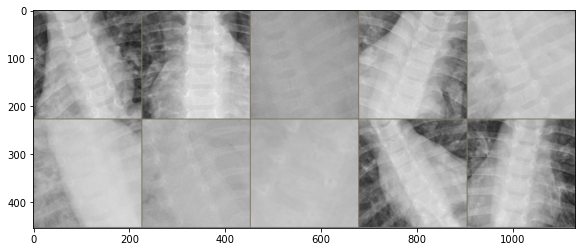

In [89]:
im= make_grid(images, nrow=5)

inv_normalize= transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224 , -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

im_inv= inv_normalize(im)

plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(),(1, 2,0)));

In [15]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3,6,3,1)
        self.conv2= nn.Conv2d(6, 18, 3, 1)
        self.conv3= nn.Conv2d(18, 25, 3, 1)
        self.fc1= nn.Linear(26*26*25, 120)
        self.fc2= nn.Linear(120, 84)
        self.fc3= nn.Linear(84, 30)
        self.fc4= nn.Linear(30, 2)
        
    def forward(self, X):
        X= F.relu(self.conv1(X))
        X= F.max_pool2d(X,2,2)
        X= F.relu(self.conv2(X))
        X= F.max_pool2d(X,2,2) 
        X= F.relu(self.conv3(X))
        X= F.max_pool2d(X,2,2)
        X=X.view(-1, 26*26*25)
        X= F.relu(self.fc1(X))  
        X=F.relu(self.fc2(X))
        X=F.relu(self.fc3(X))
        X= self.fc4(X)
        
        return F.log_softmax(X, dim=1)

In [16]:
torch.manual_seed(101)
CNN=Model()
criterion=nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(CNN.parameters(), lr= 0.001)

In [17]:
import time

start_time= time.time()

epochs=30

max_trn_batch=800
max_tst_batch=300

train_losses=[]
test_losses=[]

train_correct=[]
test_correct=[]

for i in range(epochs):
    i+=1
    
    tst_corr=0
    trn_corr=0
    
    for b, (x_train, y_train) in enumerate(train_loader):
        if b==max_trn_batch:
            break 
        b+=1
        
       
        
        y_pred= CNN(x_train)
        loss=criterion(y_pred, y_train)
        
        predicted=torch.max(y_pred.data, 1)[1]
        batch_corr=(predicted==y_train).sum()
        trn_corr+=batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%20==0:
            print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')

    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    
    for b,(x_test, y_test) in enumerate (test_loader):
        if b==max_tst_batch:
            break
            
        y_val= CNN(x_test)
        
        predicted= torch.max(y_val.data, 1)[1]
        batch_corr=(predicted==y_test).sum()
        tst_corr+= batch_corr

    loss= criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
        

total_time= time.time()- start_time
print(f'Total Time: {total_time/60} minuts')

Epoch: 1 Batch: 20 Loss: 0.7420281171798706


RuntimeError: shape '[-1, 16900]' is invalid for input of size 3969000

In [ ]:
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.legend();

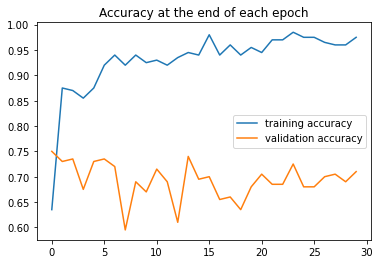

In [16]:
plt.plot([t/200 for t in train_correct], label='training accuracy')
plt.plot([t/200 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [17]:
image_index=111
CNN.eval()
with torch.no_grad():
    new_pred=CNN(test_data[image_index][0].view(1, 3, 224, 224)).argmax()

class_names[new_pred.item()]

'PNEUMONIA'